<a href="https://colab.research.google.com/github/VictorBenoiston/policy_aspects_key_concepts_retriever/blob/main/main_key_ceoncepts_extractor_model_for_llm_fowarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.2 MB/s eta 0:00:00


In [149]:
import pandas as pd
import warnings
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score
from itertools import product
from keras.callbacks import EarlyStopping
import os

In [24]:
df = pd.read_csv("data_set_ids_5_classes.csv", delimiter=',', header=None, skiprows=1, names=['text', 'category'])

# df = df[['text', 'category']]


In [25]:
df.describe(include='all')

,text,category
count,504,504
unique,252,10
top,in compliance with general and specific regula...,policy negotiation
freq,2,90


In [26]:
df.head()

,text,category
0,in compliance with general and specific regula...,data protection law
1,allowing personal data to be used with the hel...,data protection law
2,With its definition of personal data the GDPR ...,data protection law
3,Anonymization of personal data can enable a da...,data protection law
4,Please note that pseudonymization of personal ...,data protection law


In [27]:
# Avoiding unwanted warnings.
warnings.filterwarnings('ignore')

In [28]:
# Using google's universal sentence encoder (USE) to retrieve embedded semantic value
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [29]:
text_vect = embed(df['text'])
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(text_vect)

In [30]:
pd.merge(
    left = pd.concat([pd.DataFrame(x_reduced),df['category']],axis = 1),
    right = pd.DataFrame(df['category'].value_counts()).reset_index().rename(columns={"index":"category", "category":"count"}),
    on='category', how='left')

,0,1,category,count
0,226.276077,-229.443649,data protection law,38
1,-33.290558,81.345688,data protection law,38
2,118.524590,191.725937,data protection law,38
3,-69.980835,67.251633,data protection law,38
4,194.948685,263.864502,data protection law,38
...,...,...,...,...
499,81.627914,-198.741348,usge control,48
500,-98.948700,-70.414101,usge control,48
501,55.863972,-101.791931,usge control,48
502,22.749859,230.538788,usge control,48


in compliance with general and specific regulations ranging from anti-trust to GDPR and cyber-security regulations as well as sector specific regulations.allowing personal data to be used with the help of a personal data sharing intermediary that safeguards data subjects’ rights under the GDPR;With its definition of personal data the GDPR has determined an ample scope: “personal data means any information relating to an identified or identifiable natural person; an identifiable natural person is one who can be identified directly or indirectly in particular by reference to an identifier such as a name an identification number location data on online identifier or to one or more factors specific to the physical physiological genetic mental economic cultural or social identity of that natural person.”Anonymization of personal data can enable a data controller to further process the data without considering the data protection requirements provided that the data is no longer related to a

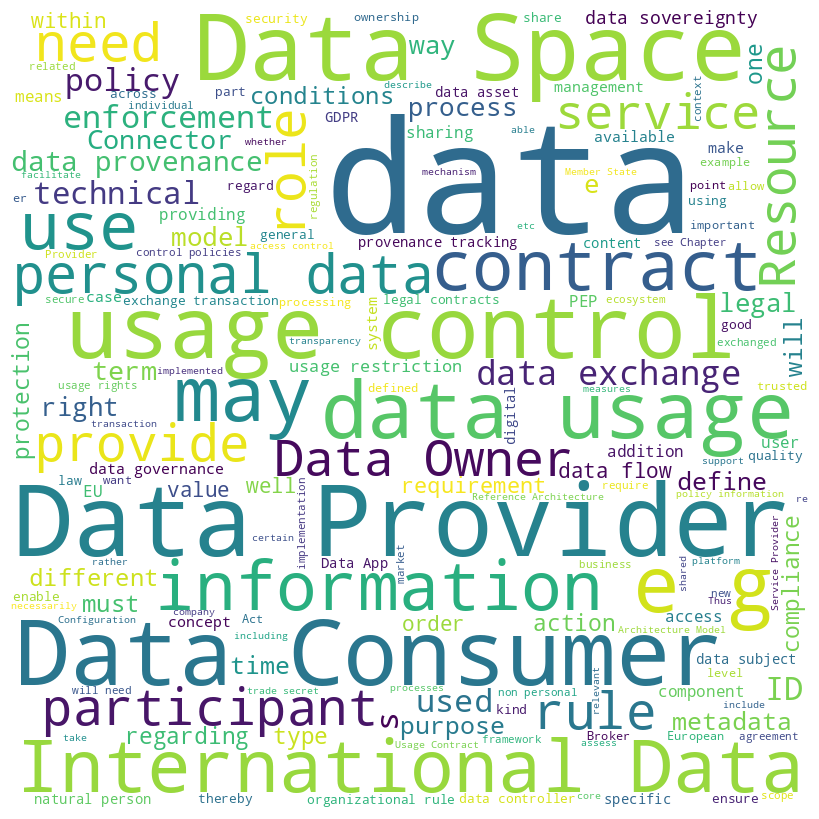

In [31]:
#Generating Word Coud

# text = df.text

text = ''

for item in df.text:
  text += "".join(item) + ""

print(text)


stopWords = set(STOPWORDS)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [32]:
sentences = df["text"].apply(lambda x: x.lower()).tolist()
# generating training data matrix
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist())

In [33]:
# df[['text', 'category']].iloc[150]

In [34]:
# Transforming catagories label
lb = LabelBinarizer().fit(list(set(df['category'].tolist())))

In [35]:
# Splitting the dataset into train, test and validation.

X, Y = np.array(embed_matrix), lb.transform(df['category'].tolist())

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
# In order to avoid overfitting, I added an early stop.

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss')

In [37]:
x_train.shape

(352, 512)

In [49]:
input_dim = 512

learning_rates = [0.001, 0.004, 0.007, 0.0001]
unit_values = [10, 30, 50, 70, 100]
epoch_values = [20, 50, 100, 130]
dropout_values = [0.2, 0.3, 0.4]

# Creating all possible combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, unit_values, epoch_values, dropout_values))

# Dictionary to store training results for each combination
all_results = {}

# Training the models for each possible combination
for learning_rate, units_value, epochs_value, dropout_value in hyperparameter_combinations:

  # Model Architecture
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.Input(shape=input_dim))
  ann.add(tf.keras.layers.Dense(units=units_value, activation='relu'))
  ann.add(tf.keras.layers.Dropout(dropout_value))
  ann.add(tf.keras.layers.Dense(units=10, activation='softmax'))

  # Compiling the model
  optimizer = tf.keras.optimizers.Adam (learning_rate=learning_rate)
  ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Training the model
  history = ann.fit(x_train, y_train, epochs=epochs_value, batch_size=10, validation_split=0.3)

  # Storing the metrics of each model
  final_train_loss = history.history['loss'][-1]
  final_train_accuracy = history.history['accuracy'][-1]
  final_val_loss = history.history['val_loss'][-1]
  final_val_accuracy = history.history['val_accuracy'][-1]

  # Storing the metrics per model in the dictionary
  model_key = f"LR_{learning_rate}_Units_{units_value}_Epochs_{epochs_value}_Dropout_{dropout_value}"
  all_results[model_key] = {
      'learning_rate': learning_rate,
      'units': units_value,
      'epochs': epochs_value,
      'dropout': dropout_value,
      'final_train_loss': final_train_loss,
      'final_train_accuracy': final_train_accuracy,
      'final_val_loss': final_val_loss,
      'final_val_accuracy': final_val_accuracy
  }


Streaming output truncated to the last 5000 lines.
25/25 [==============================] - 0s 7ms/step - loss: 1.8840 - accuracy: 0.4593 - val_loss: 2.0711 - val_accuracy: 0.3019
Epoch 42/50
25/25 [==============================] - 0s 8ms/step - loss: 1.8732 - accuracy: 0.4756 - val_loss: 2.0660 - val_accuracy: 0.3019
Epoch 43/50
25/25 [==============================] - 0s 9ms/step - loss: 1.8369 - accuracy: 0.4553 - val_loss: 2.0617 - val_accuracy: 0.3019
Epoch 44/50
25/25 [==============================] - 0s 7ms/step - loss: 1.8382 - accuracy: 0.4553 - val_loss: 2.0553 - val_accuracy: 0.3019
Epoch 45/50
25/25 [==============================] - 0s 7ms/step - loss: 1.8123 - accuracy: 0.4553 - val_loss: 2.0502 - val_accuracy: 0.3019
Epoch 46/50
25/25 [==============================] - 0s 8ms/step - loss: 1.8192 - accuracy: 0.4634 - val_loss: 2.0455 - val_accuracy: 0.3113
Epoch 47/50
25/25 [==============================] - 0s 6ms/step - loss: 1.8117 - accuracy: 0.4919 - val_loss: 2.03

In [50]:
category_counts = df['category'].value_counts()

# Display the counts
print(category_counts)

policy negotiation       90
IDS core participants    74
asset                    68
governing law            52
usge control             48
service provider         40
data protection law      38
service contract         36
policy enforcement       32
data sovereignty         26
Name: category, dtype: int64


In [51]:
# Showing all the models parameters for analysis.

for k, va in all_results.items():
  print(f'Architecture {k} parameters: ')
  for k, v in va.items():
    print(f'{k}: {v:.6f}')
  print('-------------------------------------------')

Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.2 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.200000
final_train_loss: 1.603528
final_train_accuracy: 0.577236
final_val_loss: 1.896931
final_val_accuracy: 0.396226
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.3 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.300000
final_train_loss: 1.552503
final_train_accuracy: 0.500000
final_val_loss: 1.921823
final_val_accuracy: 0.339623
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_20_Dropout_0.4 parameters: 
learning_rate: 0.001000
units: 10.000000
epochs: 20.000000
dropout: 0.400000
final_train_loss: 1.649675
final_train_accuracy: 0.459350
final_val_loss: 1.867323
final_val_accuracy: 0.415094
-------------------------------------------
Architecture LR_0.001_Units_10_Epochs_50_Dropout_0.2 parameters: 
learning_rate: 0.001000
units: 10.000

In [76]:
max_accuracy = 0.0
best_model_key = None

for model_key, results in all_results.items():
    current_accuracy = results['final_val_accuracy']

    if current_accuracy > max_accuracy:
        max_accuracy = current_accuracy
        best_model_key = model_key

print(f"Best Model: {best_model_key}, Highest Final Validation Accuracy: {max_accuracy:.4f}")

Best Model: LR_0.004_Units_50_Epochs_100_Dropout_0.2, Highest Final Validation Accuracy: 0.6509


In [101]:
# Training the best model with early stop

early_stopping = EarlyStopping(patience=20)

# Model Architecture
ann = tf.keras.models.Sequential()
ann.add(tf.keras.Input(shape=512))
ann.add(tf.keras.layers.Dense(units=50, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# Compiling the model
optimizer = tf.keras.optimizers.Adam (learning_rate=0.004)
ann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = ann.fit(x_train, y_train, epochs=100, batch_size=10, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 2.1837 - accuracy: 0.2846 - val_loss: 2.1509 - val_accuracy: 0.2925
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 1.8536 - accuracy: 0.4268 - val_loss: 1.9645 - val_accuracy: 0.3491
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 1.5264 - accuracy: 0.5285 - val_loss: 1.7903 - val_accuracy: 0.4340
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 1.2037 - accuracy: 0.6789 - val_loss: 1.6356 - val_accuracy: 0.4717
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9714 - accuracy: 0.7439 - val_loss: 1.5447 - val_accuracy: 0.5283
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.8368 - accuracy: 0.7683 - val_loss: 1.4539 - val_accuracy: 0.5472
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7100 - accuracy: 0.8089 - val_loss: 1.4277 - val_accuracy: 0.5566
Epoch 8/100


In [70]:
# Best model summary
ann.summary()

Model: "sequential_257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_512 (Dense)           (None, 50)                25650     
                                                                 
 dropout_256 (Dropout)       (None, 50)                0         
                                                                 
 dense_513 (Dense)           (None, 10)                510       
                                                                 
Total params: 26160 (102.19 KB)
Trainable params: 26160 (102.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


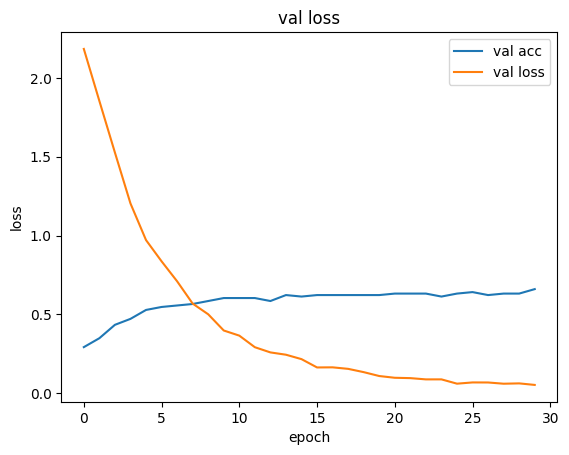

In [102]:
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val acc', 'val loss'], loc='upper right')
plt.show()

3/3 [==============================] - 0s 6ms/step


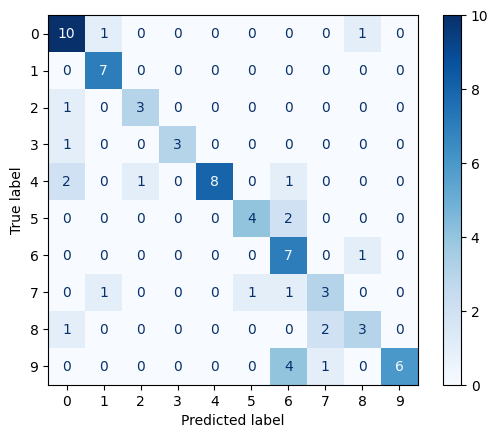

In [130]:
# label encoding for validation purposes
le = LabelEncoder().fit(sorted(list(set(df['category'].tolist()))))

class_names = le.classes_

# Confusion Matrix
cm_rm_2 = confusion_matrix(le.transform(lb.inverse_transform(np.array(y_test))),ann.predict(x_test).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [72]:
# Classification report
print(classification_report(le.transform(lb.inverse_transform(np.array(y_test))),ann.predict(x_test).argmax(axis=1)))

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.88      1.00      0.93         7
           2       0.38      0.75      0.50         4
           3       1.00      0.50      0.67         4
           4       1.00      0.50      0.67        12
           5       1.00      0.67      0.80         6
           6       0.44      0.88      0.58         8
           7       0.50      0.33      0.40         6
           8       0.50      0.50      0.50         6
           9       0.86      0.55      0.67        11

    accuracy                           0.66        76
   macro avg       0.72      0.65      0.65        76
weighted avg       0.74      0.66      0.66        76



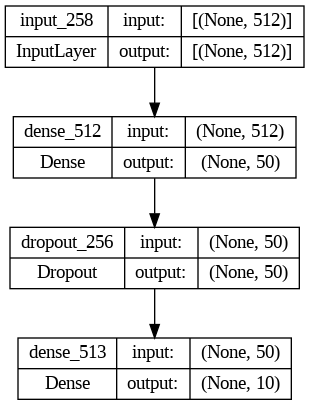

In [75]:
plot_model(ann, show_shapes=True, show_layer_names=True)

In [136]:
# Saving the best model
keras_file = 'best_model.h5'
keras.models.save_model(ann, keras_file)

In [150]:
# Converting the model for tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(ann)


In [140]:
tflite_model = converter.convert()

In [147]:
tf_lite_model = 'concept_retriever_lite.tflite'
with open (tf_lite_model, 'wb') as f:
  f.write(tflite_model)

In [160]:
standard_model_path = 'best_model.h5'
tflite_model_path = 'concept_retriever_lite.tflite'

# Get the size of the TFLite model file
lite_model_size = os.path.getsize(tflite_model_path)

# Get the size of the standard model file
standard_model_size = os.path.getsize(standard_model_path)


# Print the sizes of the models in bytes
print(f"Size of the Standard model: {standard_model_size} bytes")
print(f"Size of the TFLite model: {lite_model_size} bytes")

# # Print the sizes of the models in Kbytes
lite_model_size_kb = lite_model_size / 1024.0
standard_model_size_kb = standard_model_size / 1024.0

print('The models in Kbytes: ')
print(f"Size of the Standard model: {standard_model_size_kb:.2f} KB")
print(f"Size of the TFLite model: {lite_model_size_kb:.2f} KB")

Size of the Standard model: 340864 bytes
Size of the TFLite model: 106388 bytes
The models in Kbytes: 
Size of the Standard model: 332.88 KB
Size of the TFLite model: 103.89 KB
